In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import anndata
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np


In [26]:
cwd = os.getcwd()
adata_raw= sc.read_h5ad(cwd+'/outs/240701_kinker_anndata.h5ad')

In [28]:
def BasicScanpyPreprocessing(adata, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20,log_twice=False):
    if log_twice:
        sc.pp.log1p(adata)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor='seurat')
    #sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, random_state=random_state)
    sc.tl.umap(adata, random_state=random_state) # calculates UMAP coordinates already
    sc.tl.leiden(adata, random_state=random_state)
    return adata

In [4]:
adata = BasicScanpyPreprocessing(adata_raw, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20)

Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x000001ADF9964820>
Traceback (most recent call last):
  File "c:\Users\ndjed\Downloads\Computational_Biology\.conda\lib\site-packages\llvmlite\binding\executionengine.py", line 178, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):
KeyboardInterrupt: 
c:\Users\ndjed\Downloads\Computational_Biology\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

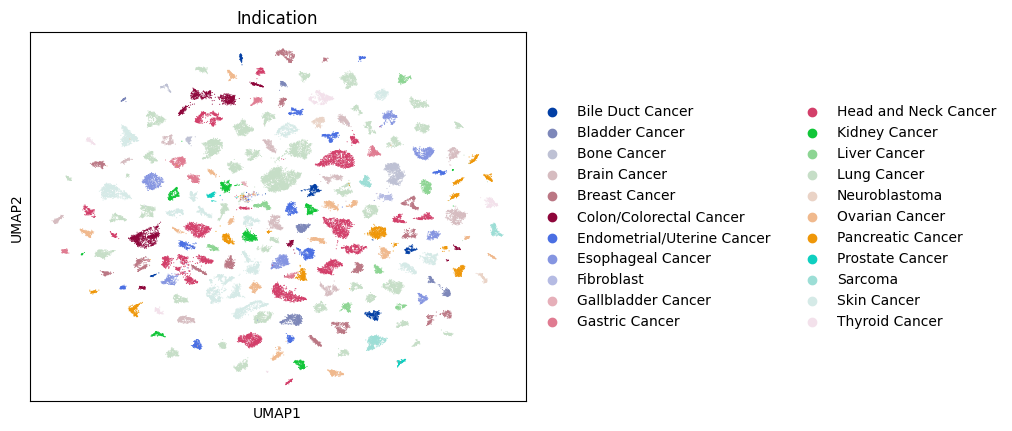

In [ ]:
sc.pl.umap(adata, color=['Indication']) 

### Corresponding Image in Kinker Paper. Seems to be tighter clusters
#### Perhaps by playing with the n_pcs parameter for more local structure they'll look more similar
![1b Figure](https://github.com/reformist/figure1lab/blob/main/images/kinker_figure1b.png?raw=true)

In [44]:
adata_local = BasicScanpyPreprocessing(adata_raw, n_top_genes=2000, n_neighbors=10, n_pcs=20, random_state=20)

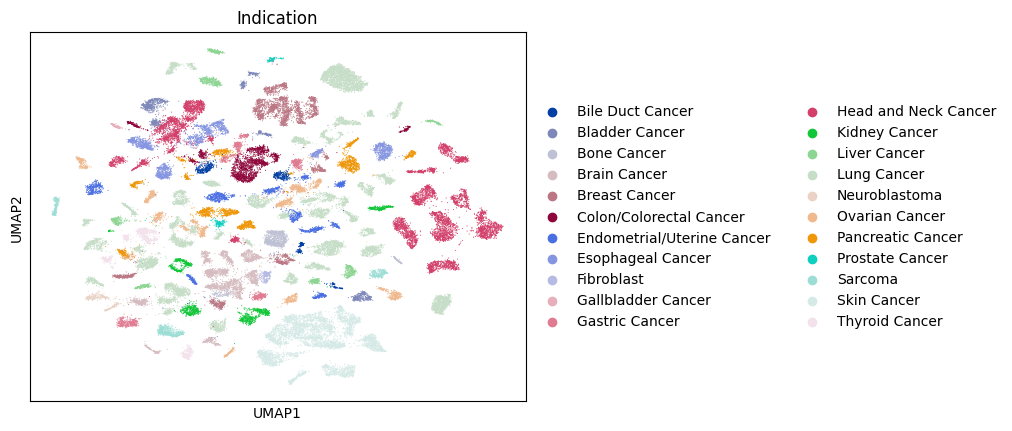

In [45]:
sc.pl.umap(adata_local, color=['Indication']) 

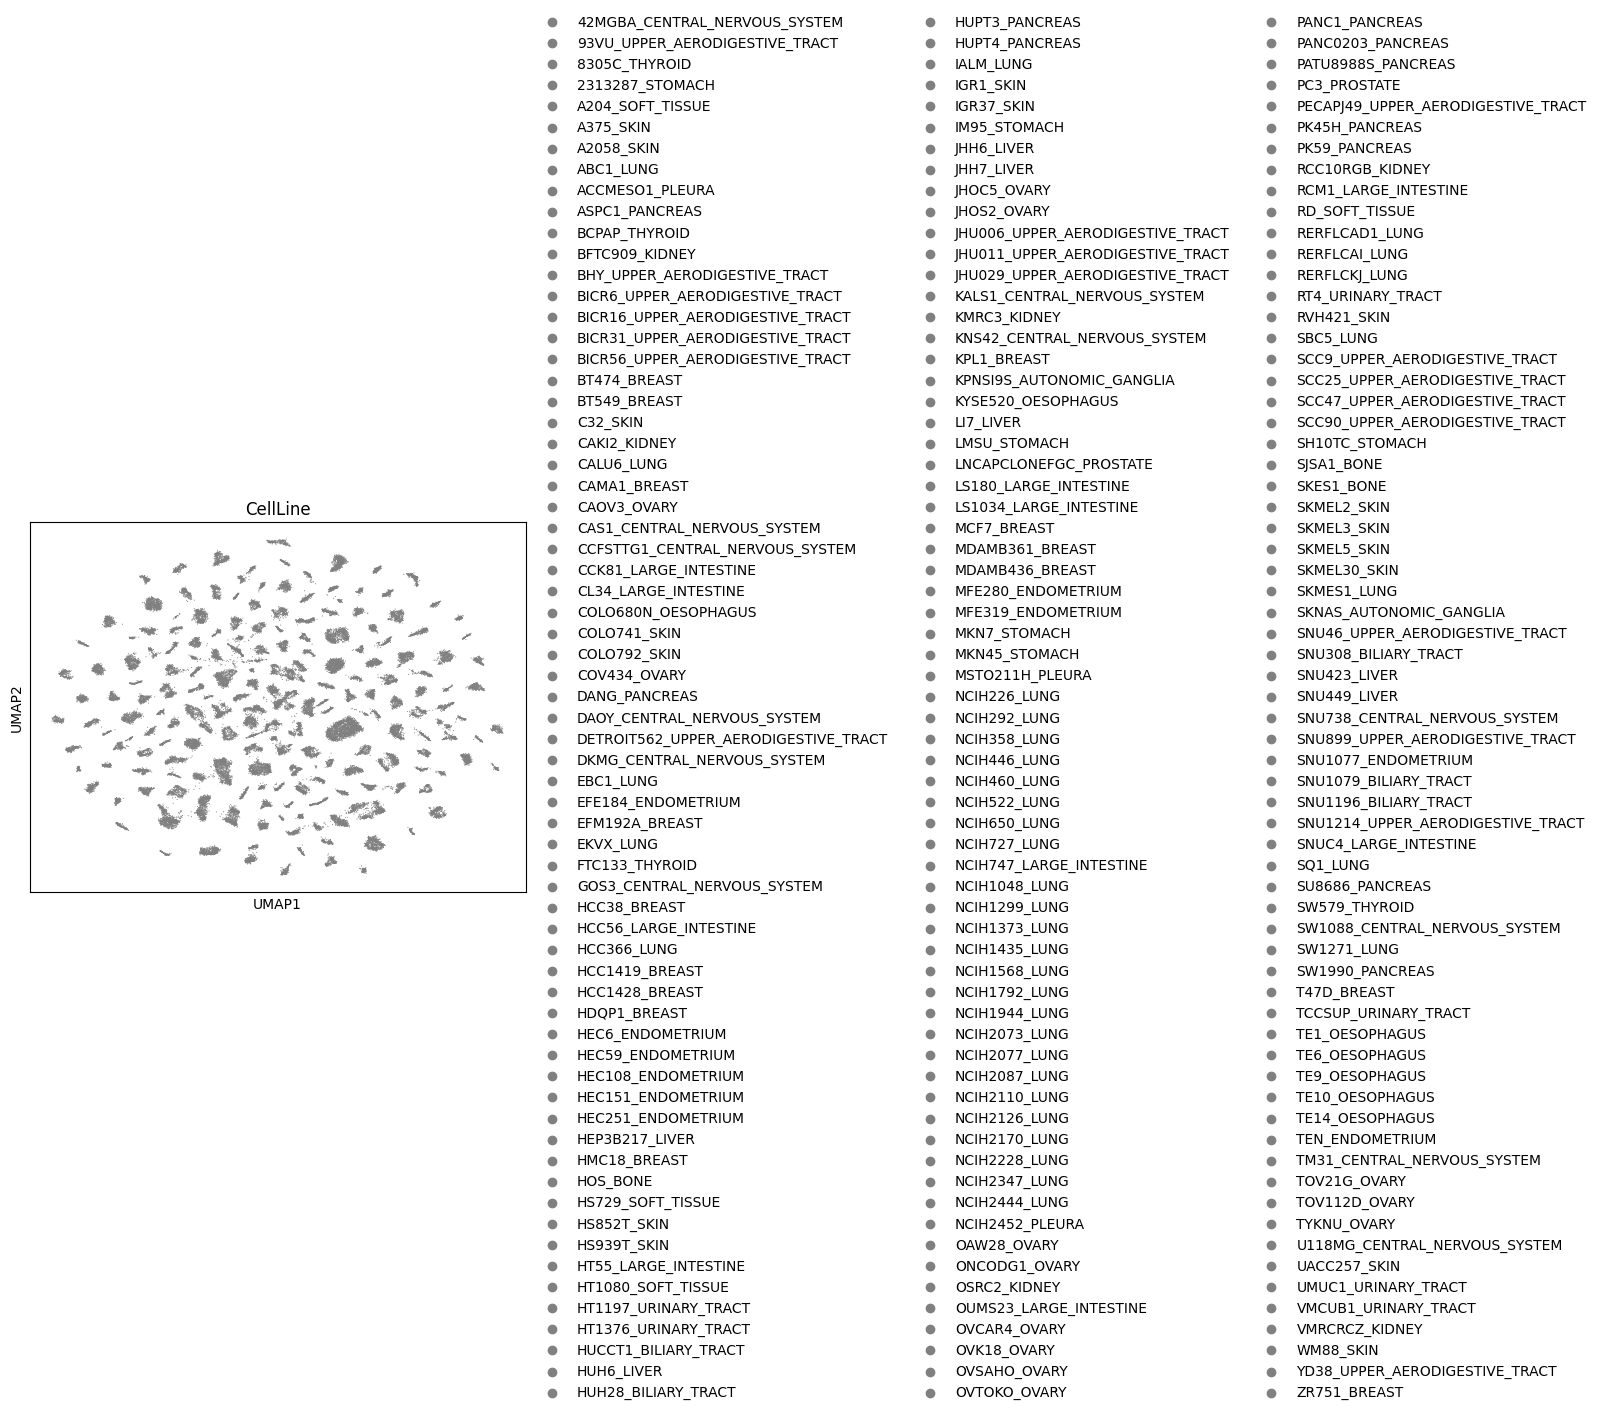

In [11]:
sc.pl.umap(adata, color=['CellLine']) # too many cell lines to discern a noticeable difference

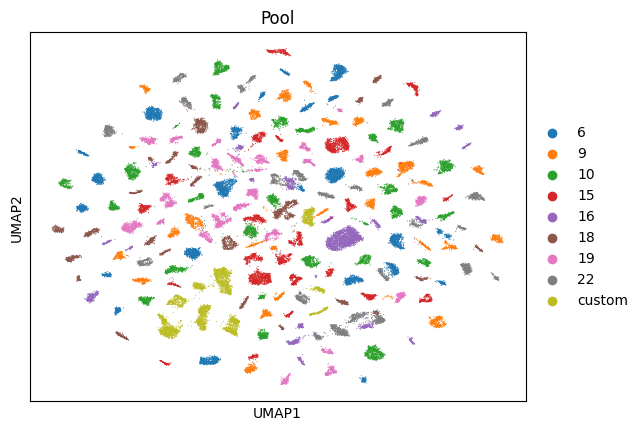

In [12]:
sc.pl.umap(adata, color=['Pool']) # indicates that pooling effects might not be a large factor as there are multiple clusters with different colors

### Recreating Figure 2b and 2d

In [36]:
def displayUMAP(adata_raw, CellLine, title="",
                eps=0.5,min_samples=5, multiple=False,
                count=3,eps_arr=[],log_twice=False):
    if multiple:
        # nrows, ncolumns
        fig, axs = plt.subplots(1,3,figsize=(15,5))
        target_cell_line = adata_raw[adata_raw.obs['CellLine']==CellLine]
        umap_coordinates = BasicScanpyPreprocessing(target_cell_line, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20, log_twice=log_twice)
        for idx, val in enumerate(eps_arr):
            db = DBSCAN(eps=float(val), min_samples=min_samples).fit(umap_coordinates.obsm['X_umap']) 
            # eps is max distance between two points to be considered a cluster
            # min_samples is how many clusters necesasry in order to form a cluster
            umap_coordinates.obs['dbscan'] = db.labels_.astype(str)
            sc.pl.umap(umap_coordinates, color=["dbscan"], title=title +f" Eps:{val}", ax=axs[idx],show=False)
        
        plt.tight_layout()
        plt.show()

    else:
        target_cell_line = adata_raw[adata_raw.obs['CellLine']==CellLine]
        umap_coordinates = BasicScanpyPreprocessing(target_cell_line, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20)
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(umap_coordinates.obsm['X_umap']) 
        # eps is max distance between two points to be considered a cluster
        # min_samples is how many clusters necesasry in order to form a cluster
        umap_coordinates.obs['dbscan'] = db.labels_.astype(str)
        sc.pl.umap(umap_coordinates, color=["dbscan"], title=title+f" Eps:{val}")

    


### Original 2b Figure

![2b Figure](https://github.com/reformist/figure1lab/blob/main/images/kinker_figure2b.png?raw=true)

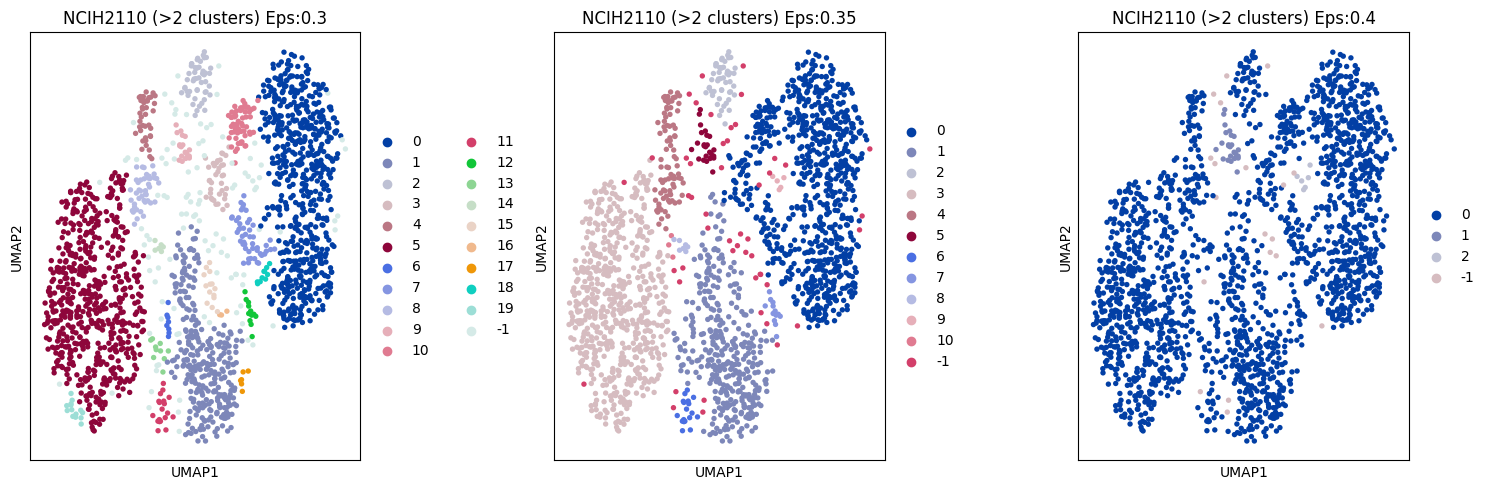

In [37]:
# only log transforming once, NCIH2110
displayUMAP(adata_raw=adata_raw, CellLine='NCIH2110_LUNG',title="NCIH2110 (>2 clusters)",multiple=True, eps_arr=[0.3,0.35,0.4])

c:\Users\ndjed\Downloads\Computational_Biology\.conda\lib\site-packages\scanpy\preprocessing\_simple.py:405: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


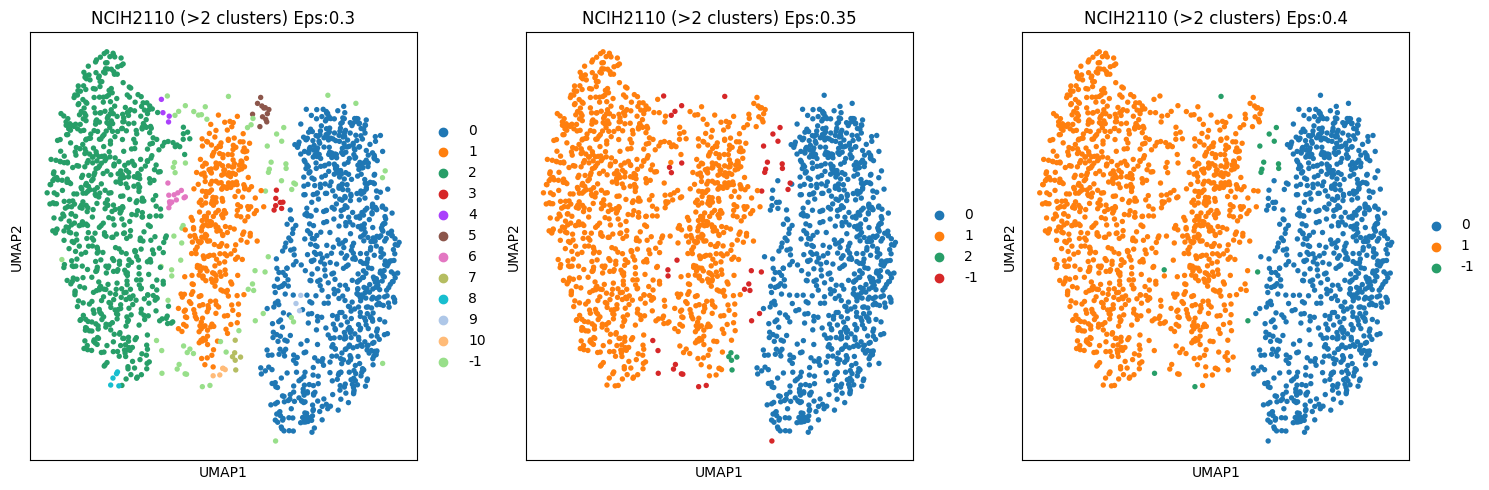

In [42]:
# if I log transform two times, the data fits their narrative a little more
displayUMAP(adata_raw=adata_raw, CellLine='NCIH2110_LUNG',title="NCIH2110 (>2 clusters)",multiple=True, eps_arr=[0.3,0.35,0.4], log_twice=True)

c:\Users\ndjed\Downloads\Computational_Biology\.conda\lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


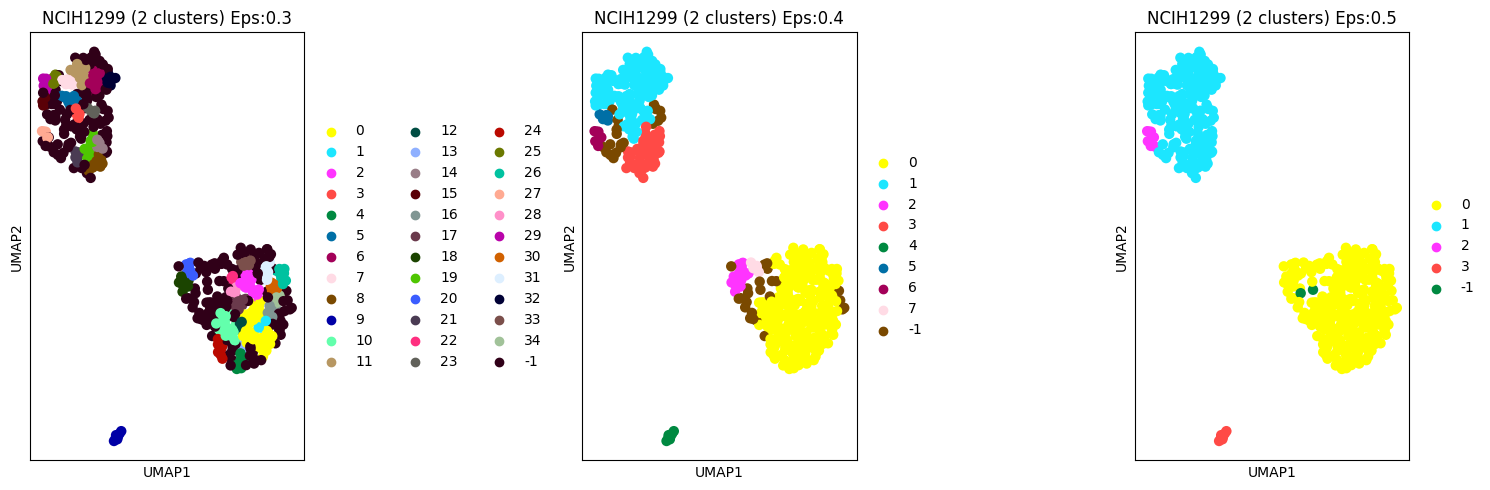

In [44]:
displayUMAP(adata_raw=adata_raw, CellLine='NCIH1299_LUNG',title="NCIH1299 (2 clusters)",multiple=True, eps_arr=[0.3,0.4,0.5])

c:\Users\ndjed\Downloads\Computational_Biology\.conda\lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


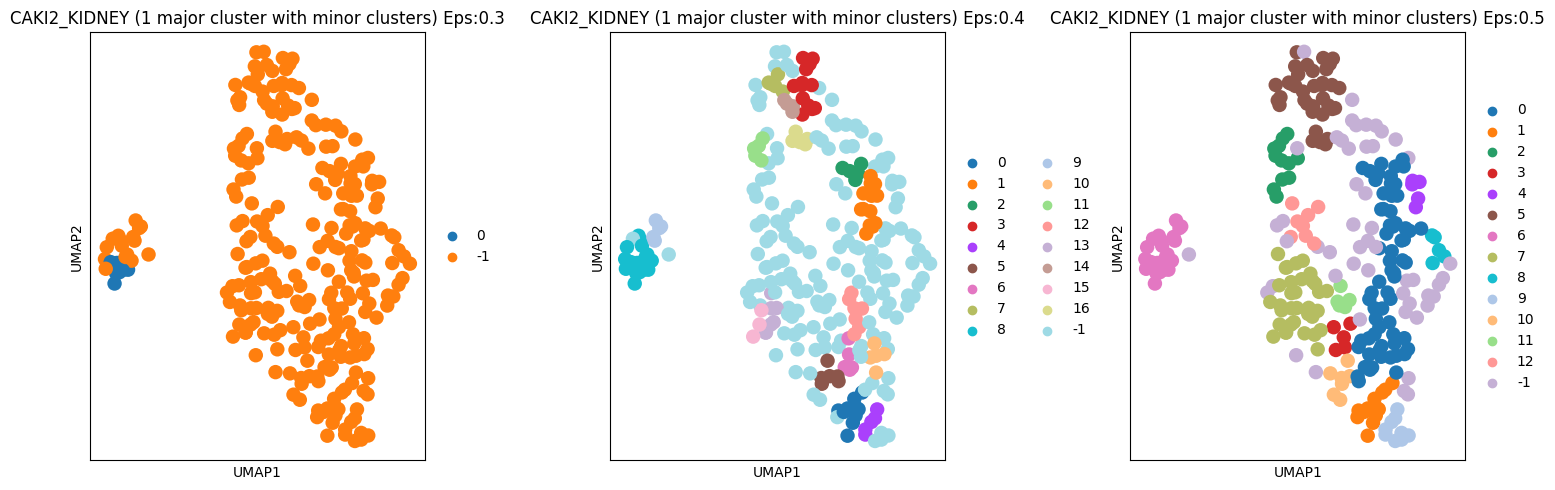

In [51]:
displayUMAP(adata_raw=adata_raw, CellLine='CAKI2_KIDNEY',title="CAKI2_KIDNEY (1 major cluster with minor clusters)",multiple=True, eps_arr=[0.3,0.4,0.5])

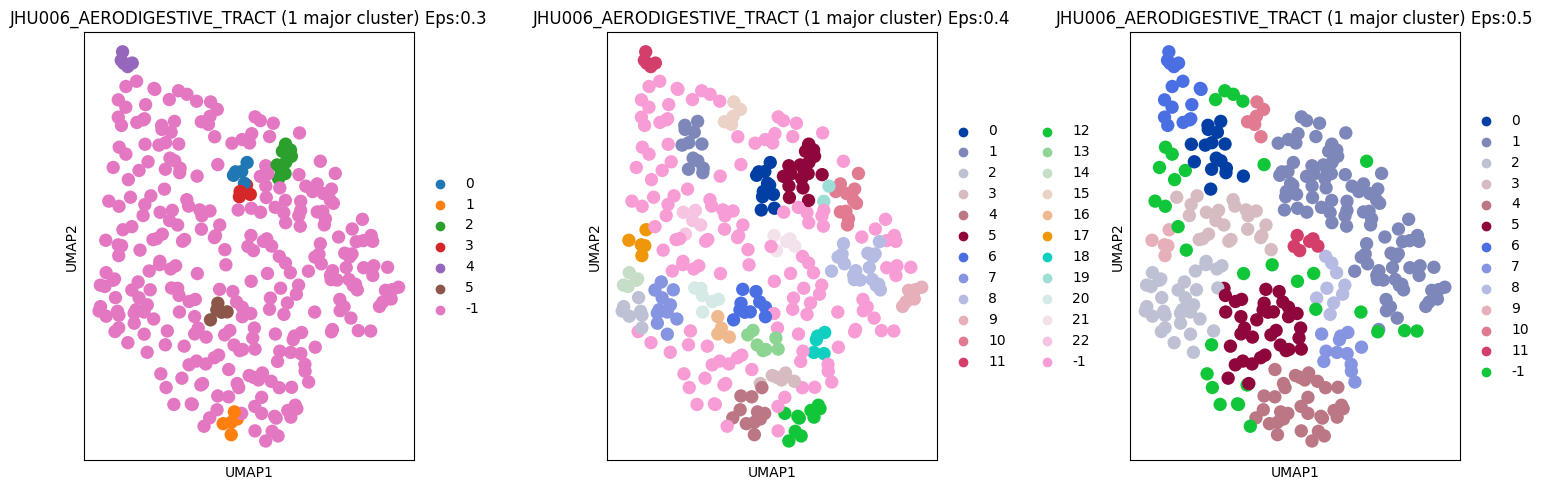

In [55]:
displayUMAP(adata_raw=adata_raw, CellLine='JHU006_UPPER_AERODIGESTIVE_TRACT',title="JHU006_AERODIGESTIVE_TRACT (1 major cluster)",multiple=True, eps_arr=[0.3,0.4,0.5])

c:\Users\ndjed\Downloads\Computational_Biology\.conda\lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


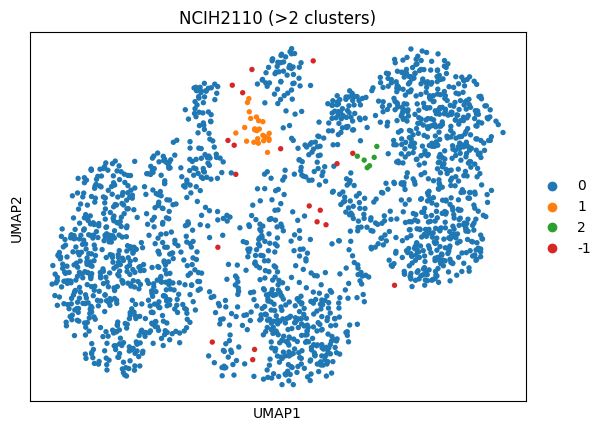

In [100]:
displayUMAP(adata_raw=adata_raw, CellLine='NCIH2110_LUNG',title="NCIH2110 (>2 clusters)", eps=0.4)

c:\Users\ndjed\Downloads\Computational_Biology\.conda\lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


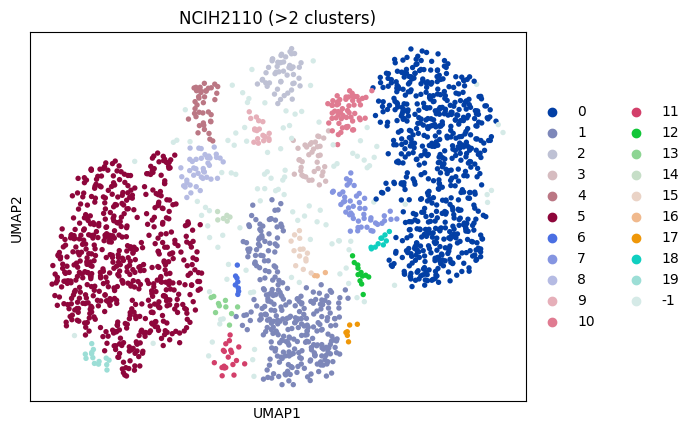

In [101]:
displayUMAP(adata_raw=adata_raw, CellLine='NCIH2110_LUNG',title="NCIH2110 (>2 clusters)", eps=0.3)

In [40]:
cell_line_list = list(adata_raw.obs['CellLine'])

In [50]:
for i in cell_line_list: 
    if "JHU006" in i: 
        print(i)

JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPPER_AERODIGESTIVE_TRACT
JHU006_UPP